In [8]:
#filter schmid et al 2005 microarray conditions


In [1]:
import pandas as pd
import tspex
import seaborn as sns

In [2]:
input_file = '../../data/genes/AtGeneExpress_CV_2020/AtGE_dev_gcRMA.txt.newline'
output_file = '../../data/genes/AtGeneExpress_CV_2020/AtGE_dev_gcRMA.txt.newline.filtered'
output_tau = '../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/genes/tissue_specific/promoters_5UTR_schmid_allfilteredgenes_TAU.txt'

In [4]:
def filter_conditions(input_file,output_file):
    """Filter unwanted plant growth conditions/tissues"""
    df = pd.read_table(input_file, sep='\t',header=0)
    #filter columns to conditions of interest
    #df = df[['Affy_identifier','AGI code','ATGE_12_A','ATGE_12_B','ATGE_12_C','ATGE_13_A','ATGE_13_B','ATGE_13_C','ATGE_14_A','ATGE_14_B','ATGE_14_C','ATGE_15_A','ATGE_15_B','ATGE_15_C','ATGE_16_A','ATGE_16_B','ATGE_16_C','ATGE_17_A','ATGE_17_B','ATGE_17_C','ATGE_18_A','ATGE_18_B','ATGE_18_C','ATGE_19_A','ATGE_19_B','ATGE_19_C','ATGE_20_A','ATGE_20_B','ATGE_20_C','ATGE_21_A','ATGE_21_B','ATGE_21_C','ATGE_22_A','ATGE_22_B','ATGE_22_C','ATGE_23_A','ATGE_23_B','ATGE_23_C','ATGE_24_A','ATGE_24_B','ATGE_24_C','ATGE_26_A','ATGE_26_B','ATGE_26_C','ATGE_27_A','ATGE_27_B','ATGE_27_C','ATGE_28_A','ATGE_28_B','ATGE_28_C','ATGE_29_A','ATGE_29_B','ATGE_29_C','ATGE_31_A','ATGE_31_B','ATGE_31_C','ATGE_32_A','ATGE_32_B','ATGE_32_C','ATGE_33_A','ATGE_33_B','ATGE_33_C','ATGE_34_A','ATGE_34_B','ATGE_34_C','ATGE_35_A','ATGE_35_B','ATGE_35_C','ATGE_36_A','ATGE_36_B','ATGE_36_C','ATGE_37_A','ATGE_37_B','ATGE_37_C','ATGE_39_A',
           # 'ATGE_39_B','ATGE_39_C','ATGE_40_A','ATGE_40_B','ATGE_40_C','ATGE_41_A','ATGE_41_B','ATGE_41_C','ATGE_42_A','ATGE_42_B','ATGE_42_C','ATGE_43_A','ATGE_43_B','ATGE_43_C','ATGE_45_A','ATGE_45_B','ATGE_45_C','ATGE_73_A','ATGE_73_B','ATGE_73_C','ATGE_76_A','ATGE_76_B','ATGE_76_C','ATGE_77_A','ATGE_77_B','ATGE_77_C','ATGE_78_A','ATGE_78_B','ATGE_78_C','ATGE_79_A','ATGE_79_B','ATGE_79_C','ATGE_81_A','ATGE_81_B','ATGE_81_C','ATGE_82_A','ATGE_82_B','ATGE_82_C','ATGE_83_A','ATGE_83_B','ATGE_83_C','ATGE_84_A','ATGE_84_B','ATGE_84_C','ATGE_87_A','ATGE_87_B','ATGE_87_C','ATGE_89_A','ATGE_89_B','ATGE_89_C','ATGE_90_A','ATGE_90_B','ATGE_90_C','ATGE_91_A','ATGE_91_B','ATGE_91_C','ATGE_92_A','ATGE_92_B','ATGE_92_C']]
    #write to output file
    #df.to_csv(output_file, sep='\t', header=1, index=False)
    return df


In [35]:
def calculate_tau(expression_data,output_tau):
    """calculate the TAU tissue specificity, log transforming the expression data in the process"""
    df = expression_data
    #remove NaN in AGI code column
    df_filtered = df.dropna()
    #remove Affy_identifier that starts with AFFX (Affymetrix normalisation probes)
    df_filtered2 = df_filtered[~df_filtered.Affy_identifier.str.startswith('AFFX')]
    
    #set gene name as index column
    df_filtered2.set_index('AGI code',inplace=True)
    
       #inverse log transform the expression data
    df_filtered2_inverselog = df_filtered2.copy()
    df_filtered2_inverselog.iloc[:,1:] = df_filtered2.iloc[:,1:].apply(lambda x: 2**x)
    df_filtered2=df_filtered2_inverselog.copy()
    #merge columns that are replicates
    #first make a list of all final column names
    list_of_conditions = []
    for col in df_filtered2.columns:
        if col == 'Affy_identifier':
            pass
        else:
            

            if col[:-2] in list_of_conditions:
                pass
            else:
                list_of_conditions.append(col[:-2])
    
    #create copy of df
    mean_replicates = df_filtered2.copy()
    #merge replicates and calculate the mean
    for ID in list_of_conditions:
        tempdf= mean_replicates.loc[:,mean_replicates.columns.str.contains(ID)].mean(axis=1).reset_index()
        tempdf.columns = ['AGI code', ID]
        #merge with original df
        df_filtered2 = pd.merge(df_filtered2, tempdf, how='left', on='AGI code')

    #remove Affy_identifier column
    df_filtered2.drop('Affy_identifier', inplace=True, axis=1)
    
    #set index
    df_filtered2.set_index('AGI code', inplace=True)
    
    #select only columns in the list
    df_filtered2 = df_filtered2[[name for name in list_of_conditions]]
    
        
    
    
    return df_filtered2
    
    #Filter genes which have no expression
    df_filtered3 = df_filtered2.loc[(df_filtered2 > 0).any(axis=1)]
    
    #Create copy of the df
    data = df_filtered3.copy()
    
    #create TissueSpecificity object
    tso = tspex.TissueSpecificity(data, 'tau', log=True)
    #create tau df
    tso_df = pd.DataFrame(tso.tissue_specificity)
    tso_df.columns = ['TAU']
        
    #save output file
    tso_df.to_csv(output_tau, sep='\t', header=1)
    
    return tso,tso_df

In [36]:
tso = calculate_tau(expression_data,output_tau)

In [6]:
expression_data = filter_conditions(input_file,output_file)

In [7]:
tso,tso_df = calculate_tau(expression_data,output_tau)

ValueError: too many values to unpack (expected 2)

In [208]:
tso_df

,AGI code,TAU
0,orf25,0.1725
1,nad4L,0.1646
2,orf149,0.0684
3,orf275,0.0958
4,orf122c,0.2276
...,...,...
22741,At2g32910,0.0565
22742,At2g32890,0.3627
22743,At2g32880,0.2291
22744,At2g32860,0.1594


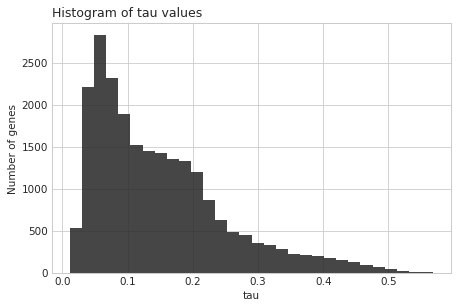

In [204]:
tso.plot_histogram()

In [187]:
tso.plot_heatmap(threshold=0.8, sort_genes=True, use_zscore=True, gene_names=False)


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/tspex/core/specificity_class.py:210: UserWarning: There is no gene with tissue-specificity value above the threshold.
  'There is no gene with tissue-specificity value above the threshold.'


In [112]:
df2 = loader(output_file)